In [81]:
from data_loader import load_orl

data = load_orl()
train, test = data["train"], data["test"]
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Train set: 360 samples
Test set: 40 samples


In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

Displaying 2 examples from the ORL training set:


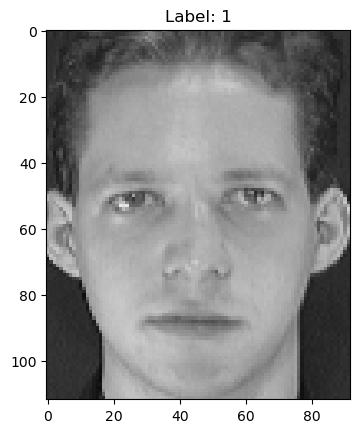

Example 1: Label = 1


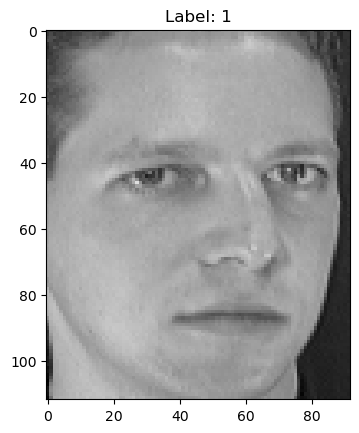

Example 2: Label = 1


In [100]:
train_data = data['train']

print("Displaying 2 examples from the ORL training set:")
for i in range(2):
    instance = train_data[i]
    image_matrix = instance['image']
    image_label = instance['label']

    plt.imshow(image_matrix, cmap='gray')
    plt.title(f"Label: {image_label}")
    plt.show()
    print(f"Example {i+1}: Label = {image_label}")

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(19712, 1024)
        self.fc2 = nn.Linear(1024, 40)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [107]:
def prepare_data(raw_data, batch_size=16):
    # Step 1: Extract images and labels
    images = np.array([item['image'] for item in raw_data]).astype(np.float32)
    labels = np.array([item['label']-1 for item in raw_data]).astype(np.int64)

    # Step 2: Ensure the correct shape: swap height and width
    images = images.reshape(-1, 3, 112, 92)  # Ensure that the shape is (N, 3, 112, 92)
    
    # Use only the R channel (channel 0 in the RGB image)
    images = images[:, 0, :, :]  # Select the first channel (R channel)

    # Step 3: Normalize pixel values to [0, 1]
    images /= 255.0

    # Step 4: Reshape to (N, 1, 112, 92) for CNN input
    images = images.reshape(-1, 1, 112, 92)

    # Step 5: Convert to PyTorch tensors
    tensor_images = torch.from_numpy(images)
    tensor_labels = torch.from_numpy(labels)

    # Step 6: Create dataset and dataloader
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Load raw data
data = load_orl()

# Prepare loaders
train_loader = prepare_data(data['train'])
test_loader = prepare_data(data['test'])

In [109]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, num_epochs=10):
    model.train()  # training mode
    epoch_losses = []
    loss_history = []  # To store individual batch losses

    for epoch in range(num_epochs):
        running_loss = 0.0  
        epoch_total_loss = 0.0 
        num_batches = 0  

        for batch_idx, (inputs, labels) in enumerate(train_loader):
         
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track losses
            running_loss += loss.item()
            epoch_total_loss += loss.item()
            loss_history.append(loss.item())
            num_batches += 1

            # Print loss for every 5 batches
            if batch_idx % 5 == 4:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0  # Reset running loss

        # Calculate and print average loss for the current epoch
        avg_loss = epoch_total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    print("Finished Training")
    return epoch_losses, loss_history


Using device: cpu


In [113]:
# Train the model
train_losses, loss_history = train(model, train_loader, num_epochs=10)



Epoch [1/10], Batch [5/23], Loss: 0.1880
Epoch [1/10], Batch [10/23], Loss: 0.1858
Epoch [1/10], Batch [15/23], Loss: 0.1845
Epoch [1/10], Batch [20/23], Loss: 0.1837
Epoch [1/10], Average Loss: 3.7063
Epoch [2/10], Batch [5/23], Loss: 0.1798
Epoch [2/10], Batch [10/23], Loss: 0.1717
Epoch [2/10], Batch [15/23], Loss: 0.1612
Epoch [2/10], Batch [20/23], Loss: 0.1540
Epoch [2/10], Average Loss: 3.2834
Epoch [3/10], Batch [5/23], Loss: 0.1377
Epoch [3/10], Batch [10/23], Loss: 0.1322
Epoch [3/10], Batch [15/23], Loss: 0.1340
Epoch [3/10], Batch [20/23], Loss: 0.1340
Epoch [3/10], Average Loss: 2.6398
Epoch [4/10], Batch [5/23], Loss: 0.1203
Epoch [4/10], Batch [10/23], Loss: 0.1057
Epoch [4/10], Batch [15/23], Loss: 0.0981
Epoch [4/10], Batch [20/23], Loss: 0.0996
Epoch [4/10], Average Loss: 2.0678
Epoch [5/10], Batch [5/23], Loss: 0.0846
Epoch [5/10], Batch [10/23], Loss: 0.0703
Epoch [5/10], Batch [15/23], Loss: 0.0640
Epoch [5/10], Batch [20/23], Loss: 0.0655
Epoch [5/10], Average Los

In [115]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    return accuracy

# Usage
print("\nStarting evaluation...")
evaluate_model(model, test_loader)


Starting evaluation...
Accuracy on test set: 85.00%


85.0

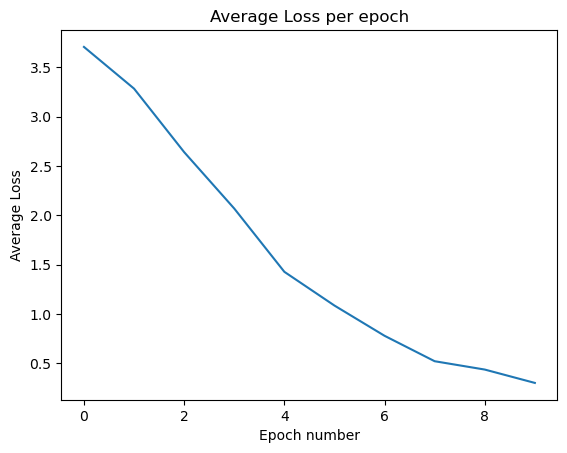

In [119]:
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch number')
plt.ylabel('Average Loss')
plt.title('Average Loss per epoch')
plt.show()